This notebook explains the process of "cooking" a model, i.e. the iterative process of building a model exploiting human knowledgeand the Shapley Values from SHAP.

The dataset used is extracted from the World Bank Open Data (https://data.worldbank.org/). We will build a model that will order the countries according to the GDP per capita. We will use the 80% of the countries as training dataset, 10% of the countries as the validation dataset, and the remaining 10% of the countries as the test dataset.

The features we included in this dataset are:

* Population: The population of the country (total).
* Health: UHC (Universal health coverage) service coverage index
* GINI: Deviation from a perfectly equal distribution of the income in the country.
* Industry: Industry (including construction), value added (% of GDP)
* Inflation: Inflation, consumer prices (annual %)
* Children OoS: Children out of school (% of primary school age)
* Equality: Law mandates equal remuneration for females and males for work of equal value (1=yes; 0=no)
* Pregnant Adolescents: Adolescent fertility rate (births per 1,000 women ages 15-19)

The differeces between this work and the presented in the paper are the following:

* MAE vs. RMSE: This example will use the Mean Average Error as the Error instead of the Root Mean Square Error.
* MAE vs. NDCG: We will also use the MAE to metric how good is our model in comparison to the NDCG.
* The code from comparison.py is structured in a loop. We unloop this process to facilitate the explanation. 







Initial step: To load the data from the excel file from World Bank.

In [2]:
import pandas
import numpy
from sklearn.metrics import mean_absolute_error


data_pre = pandas.read_excel(open("Data_Extract_From_World_Development_Indicators.xlsx",'rb'),sheet_name="Data")
data = pandas.DataFrame(columns=['Population','Health',"GINI",'Industry','Children OoS','Inflation','Equality', 'Pregnant Adolescents','GDP per capita'])
countries = set(data_pre["Country Name"].tolist())
data_pre =data_pre.replace('..',numpy.NaN)

for country in countries:
    data = data.append(pandas.Series(name = country))
    data.at[country,'Population'] = data_pre.loc[(data_pre['Country Name']==country) & (data_pre['Series Name']=='Population, total')]['2015 [YR2015]'].values[0]
    data.at[country,'Health'] = data_pre.loc[(data_pre['Country Name']==country) & (data_pre['Series Name']=='UHC service coverage index')]['2015 [YR2015]'].values[0]
    data.at[country,'GINI'] = data_pre.loc[(data_pre['Country Name']==country) & (data_pre['Series Name']=='GINI index (World Bank estimate)')]['2015 [YR2015]'].values[0]
    data.at[country,'Industry'] = data_pre.loc[(data_pre['Country Name']==country) & (data_pre['Series Name']=='Industry (including construction), value added (% of GDP)')]['2015 [YR2015]'].values[0]
    data.at[country,'Children OoS'] = data_pre.loc[(data_pre['Country Name']==country) & (data_pre['Series Name']=='Children out of school (% of primary school age)')]['2015 [YR2015]'].values[0]
    data.at[country,'Inflation'] = data_pre.loc[(data_pre['Country Name']==country) & (data_pre['Series Name']=='Inflation, consumer prices (annual %)')]['2015 [YR2015]'].values[0]
    data.at[country,'Equality'] = data_pre.loc[(data_pre['Country Name']==country) & (data_pre['Series Name']=='Law mandates equal remuneration for females and males for work of equal value (1=yes; 0=no)')]['2015 [YR2015]'].values[0]
    data.at[country,'Pregnant Adolescents'] = data_pre.loc[(data_pre['Country Name']==country) & (data_pre['Series Name']=='Adolescent fertility rate (births per 1,000 women ages 15-19)')]['2015 [YR2015]'].values[0]
    data.at[country,'GDP per capita'] = data_pre.loc[(data_pre['Country Name']==country) & (data_pre['Series Name']=='GDP per capita (current US$)')]['2015 [YR2015]'].values[0]

In data we have the information of each country. See for instance the information from Paraguay:

In [2]:
data.loc['Paraguay']

Population              6.68875e+06
Health                           68
GINI                           47.6
Industry                    34.6276
Children OoS                    NaN
Inflation                     3.129
Equality                          1
Pregnant Adolescents        71.4732
GDP per capita               5406.7
Name: Paraguay, dtype: object

second step: To pre-process the data.

In [3]:
data = data.dropna(subset=['GDP per capita'])
    
from sklearn.model_selection import train_test_split

train, validationTest = train_test_split(data, test_size=0.2)
validation, test = train_test_split(validationTest, test_size=0.5)

trainY = train['GDP per capita'].astype('int32')
validationY = validation['GDP per capita'].astype('int32')
testY = test['GDP per capita'].astype('int32')
trainX = train.drop(['GDP per capita'], axis=1).astype('float32')
validationX = validation.drop(['GDP per capita'], axis=1).astype('float32')
testX = test.drop(['GDP per capita'], axis=1).astype('float32')

third step: train a model and analyse it.

* i_features corresponds to the features that we will discard based on our analysis
* previous_i_features is a copy of the i_features from the previous step
* initialPerformance is the analy

In [4]:
from sklearn.metrics import mean_absolute_error

import catboost as cbt

i_features = set()
previous_i_features = set()
previousError = -1
initialPerformance= -1
finalPerformance = -1
previousModel =-1

trainValidationX = pandas.concat([trainX,validationX], ignore_index=False)
trainValidationY = pandas.concat([trainY,validationY], ignore_index=False)


cbt_model_dfgpu_previ = cbt.CatBoostRegressor(loss_function='MAE',ignored_features = i_features,metric_period = 500,train_dir="./entrenament/",bootstrap_type = 'Bernoulli',subsample = 0.66,eval_metric = 'MAE',early_stopping_rounds = 500,iterations=100000,random_seed=99,use_best_model=True)
cbt_model_dfgpu_previ.fit(trainX,trainY,eval_set=(validationX,validationY))

predictionValidation = cbt_model_dfgpu_previ.predict(validationX)
previousError = mean_absolute_error(validationY,predictionValidation)

cbt_model_dfgpu = cbt.CatBoostRegressor(loss_function='MAE',ignored_features = i_features,metric_period = 500,train_dir="./entrenament/",bootstrap_type = 'Bernoulli',subsample = 0.66,eval_metric = 'MAE',iterations=cbt_model_dfgpu_previ.best_iteration_,random_seed=99)
cbt_model_dfgpu.fit(trainValidationX,trainValidationY)




0:	learn: 12387.2630531	test: 23430.5210050	best: 23430.5210050 (0)	total: 65.6ms	remaining: 1h 49m 19s
500:	learn: 1842.6919000	test: 13854.6172403	best: 13409.0463967 (221)	total: 1.24s	remaining: 4m 7s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 13409.0464
bestIteration = 221

Shrink model to first 222 iterations.
0:	learn: 13573.3125047	total: 2.07ms	remaining: 456ms
220:	learn: 4229.3262951	total: 358ms	remaining: 0us


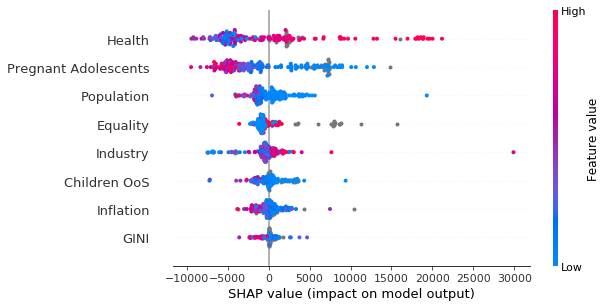

In [14]:
import shap
shap_values_train = cbt_model_dfgpu.get_feature_importance(cbt.Pool(trainValidationX,trainValidationY), type='ShapValues')
shap.summary_plot(numpy.array(shap_values_train[:,:-1]),features=numpy.array(trainValidationX),feature_names=trainValidationX.columns)

In [28]:
pos = data.columns.get_loc('Industry')
maxPos = [val[pos] for val in shap_values_train]
maxPosIndex = maxPos.index(max(maxPos))
maxPosIndex

26

In [29]:
trainValidationX.iloc[26]

Population              37470.000000
Health                           NaN
GINI                             NaN
Industry                   37.260265
Children OoS                0.033490
Inflation                        NaN
Equality                         NaN
Pregnant Adolescents             NaN
Name: Liechtenstein, dtype: float32

Liechtenstein is unique: very small, very rich, with very few information. We might consider to remove the instance in our training dataset to obtain a fairer model.

In [31]:
trainValidationX = trainValidationX.drop('Liechtenstein')